# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from tqdm import tqdm
import math
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

from pathlib import Path
import joblib

# User Config

In [2]:
class Config:
    def __init__(self):
        self.dataset = 'Data/diabetes.csv'
        self.dataset_name = "Diabetes"
        self.features = ['Pregnancies',
                         'PlasmaGlucose',
                         'DiastolicBloodPressure',
                         'TricepsThickness',
                         'SerumInsulin',
                         'BMI',
                         'DiabetesPedigree',
                         'Age'
                        ]
        self.label = 'Diabetic'
        
#         self.dataset = 'Data/penguins.csv'
#         self.features = ['CulmenLength',
#                          'CulmenDepth',
#                          'FlipperLength',
#                          'BodyMass'
#                         ]
#         self.label = 'Species'
        
#         self.dataset = 'Data/breast-cancer-wisconsin.csv'
#         self.dataset_name = "Breast Cancer"
#         self.features = ["Clump Thickness",
#                          "Uniformity of Cell Size",
#                          "Uniformity of Cell Shape",
#                          "Marginal Adhesion",
#                          "Single Epithelial Cell Size",
#                          "Bare Nuclei",
#                          "Bland Chromatin",
#                          "Normal Nucleoli",
#                          "Mitoses"
#                         ]
#         self.label = 'Class'
        
        self.random_seed = 101
        
config = Config()

# Read File

In [3]:
# load the training dataset
df = pd.read_csv(config.dataset)
df.head()

PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
0    1354778            0            171                      80   
1    1147438            8             92                      93   
2    1640031            7            115                      47   
3    1883350            9            103                      78   
4    1424119            1             85                      59   

   TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  
0                34            23  43.509726          1.213191   21         0  
1                47            36  21.240576          0.158365   23         0  
2                52            35  41.511523          0.079019   23         0  
3                25           304  29.582192          1.282870   43         1  
4                27            35  42.604536          0.549542   22         0

# EDA

In [4]:
# Understand number of rows and columns 
df.shape

(15000, 10)

In [5]:
# Understand what your columns are and data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [6]:
# Understand the descriptive statistics of your numerical data
df.describe()

PatientID   Pregnancies  PlasmaGlucose  DiastolicBloodPressure  \
count  1.500000e+04  15000.000000   15000.000000            15000.000000   
mean   1.502922e+06      3.224533     107.856867               71.220667   
std    2.892534e+05      3.391020      31.981975               16.758716   
min    1.000038e+06      0.000000      44.000000               24.000000   
25%    1.252866e+06      0.000000      84.000000               58.000000   
50%    1.505508e+06      2.000000     104.000000               72.000000   
75%    1.755205e+06      6.000000     129.000000               85.000000   
max    1.999997e+06     14.000000     192.000000              117.000000   

       TricepsThickness  SerumInsulin           BMI  DiabetesPedigree  \
count      15000.000000  15000.000000  15000.000000      15000.000000   
mean          28.814000    137.852133     31.509646          0.398968   
std           14.555716    133.068252      9.759000          0.377944   
min            7.000000     14.000000     18.200512          0.078044   
25%           15.000000     39.000000     21.259887          0.137743   
50%           31.000000     83.000000     31.767940          0.200297   
75%           41.000000    195.000000     39.259692          0.616285   
max           93.000000    799.000000     56.034628          2.301594   

                Age      Diabetic  
count  15000.000000  15000.000000  
mean      30.137733      0.333333  
std       12.089703      0.471420  
min       21.000000      0.000000  
25%       22.000000      0.000000  
50%       24.000000      0.000000  
75%       35.000000      1.000000  
max       77.000000      1.000000

In [7]:
# Check for null values
df.isna().sum() / len(df)*100
# sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

PatientID                 0.0
Pregnancies               0.0
PlasmaGlucose             0.0
DiastolicBloodPressure    0.0
TricepsThickness          0.0
SerumInsulin              0.0
BMI                       0.0
DiabetesPedigree          0.0
Age                       0.0
Diabetic                  0.0
dtype: float64

In [8]:
# notice imbalanced data set
df[config.label].value_counts()

0    10000
1     5000
Name: Diabetic, dtype: int64

In [9]:
# benign = df[df[config.label]==2]
# benign_sample = benign.sample(n=239, replace=False, random_state=config.random_seed, ignore_index=True)
# benign_sample

# malig = df[df[config.label]==4]
# malig

# df = pd.concat([benign_sample, malig], ignore_index=True)
# df['Class'] = [0 if x==2 else 1 for x in df['Class'] ]

In [10]:
# peng0 = df[df[config.label]==0]
# peng0_sample = peng0.sample(n=68, replace=False, random_state=config.random_seed, ignore_index=True)
# peng0_sample

# peng1 = df[df[config.label]==1]
# peng1_sample = peng1.sample(n=68, replace=False, random_state=config.random_seed, ignore_index=True)
# peng1_sample

# peng2 = df[df[config.label]==2]
# peng2

# df = pd.concat([peng0_sample, peng1_sample, peng2], ignore_index=True)

In [11]:
non_diabetic = df[df['Diabetic']==0]
non_diabetic_sample = non_diabetic.sample(frac=0.5, replace=False, random_state=config.random_seed, ignore_index=True)
non_diabetic_sample

diabetic = df[df['Diabetic']==1]
diabetic

df = pd.concat([non_diabetic_sample, diabetic], ignore_index=True)

In [12]:
df[config.label].value_counts()

0    5000
1    5000
Name: Diabetic, dtype: int64

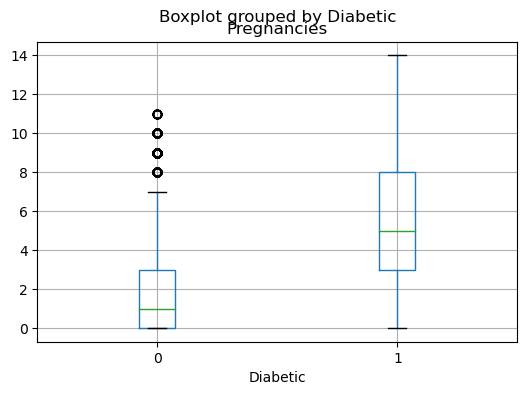

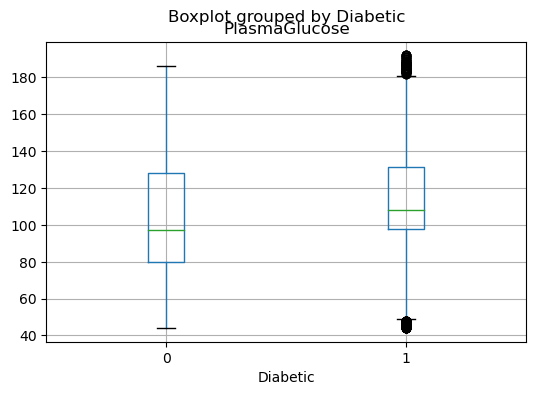

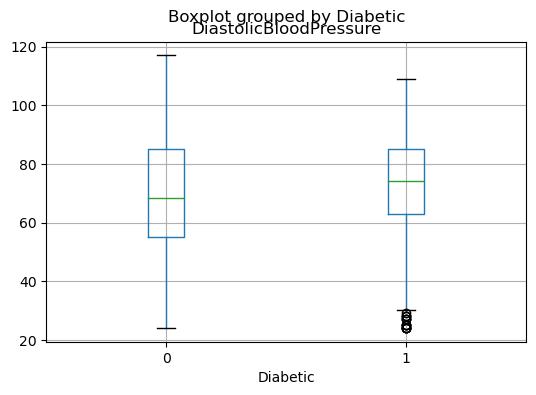

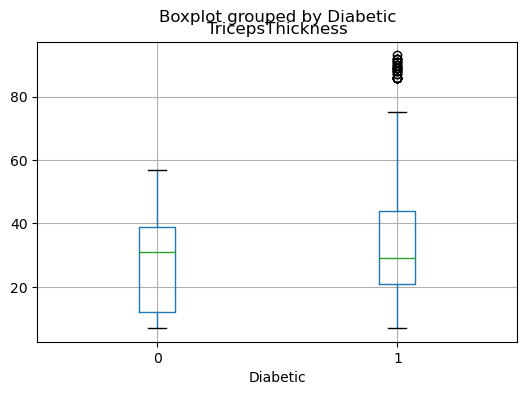

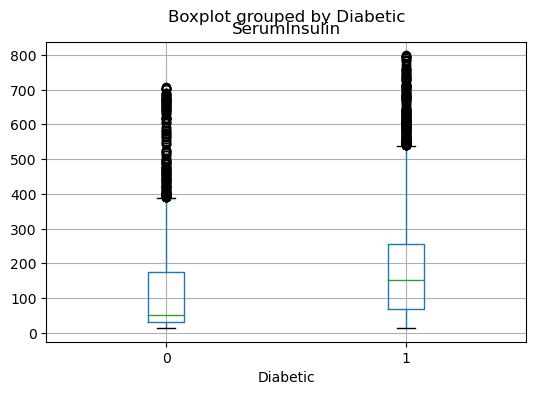

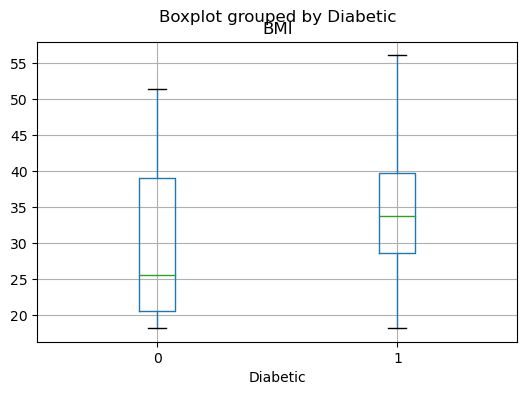

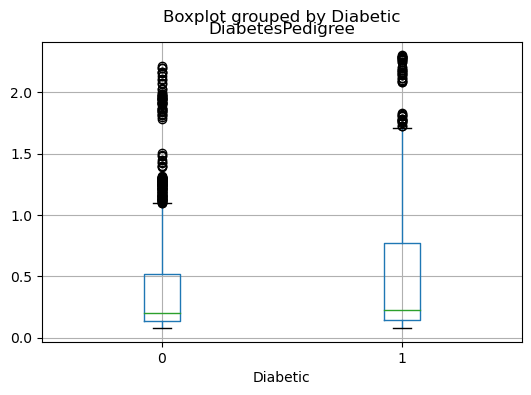

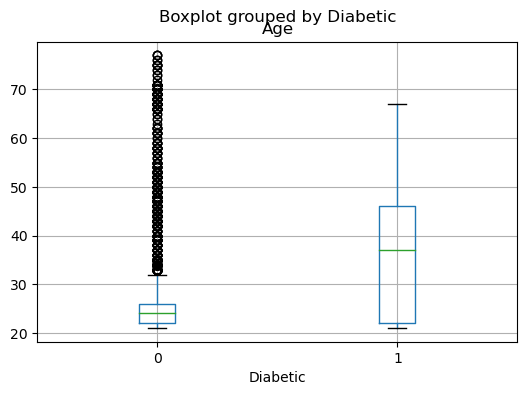

In [13]:
for col in config.features:
    df.boxplot(column=col, by=config.label, figsize=(6,4))
    # plt.title(col)
plt.show()

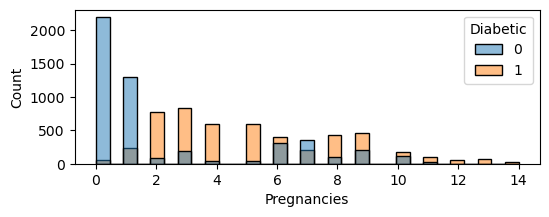

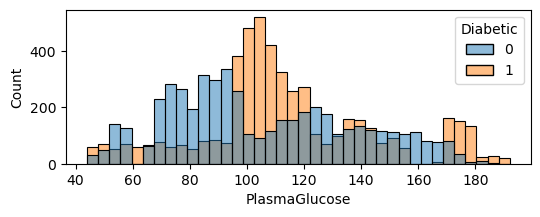

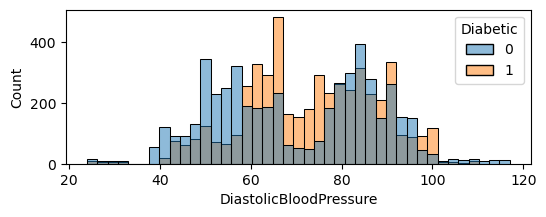

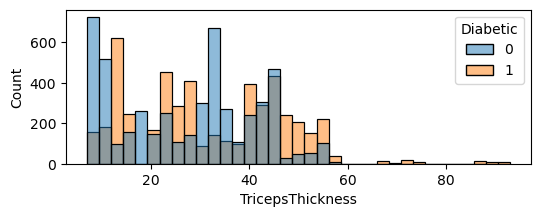

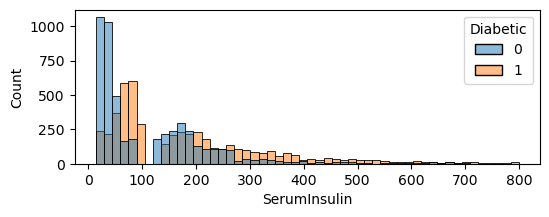

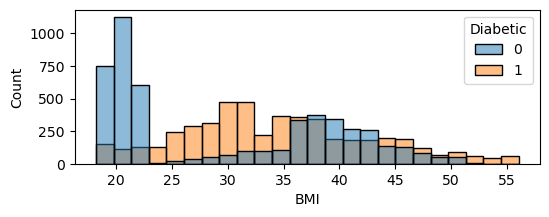

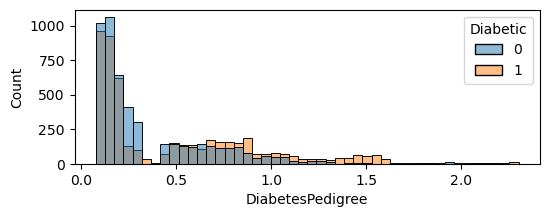

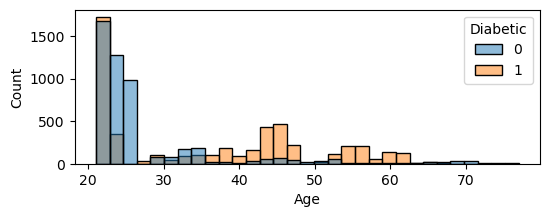

In [14]:
for col in config.features:
#     fg = sns.FacetGrid(df, col=config.label)
#     fg.map(plt.hist, col)
    plt.figure(figsize=(6,2))
    sns.histplot(data=df, x=col, hue=config.label)
    plt.show()

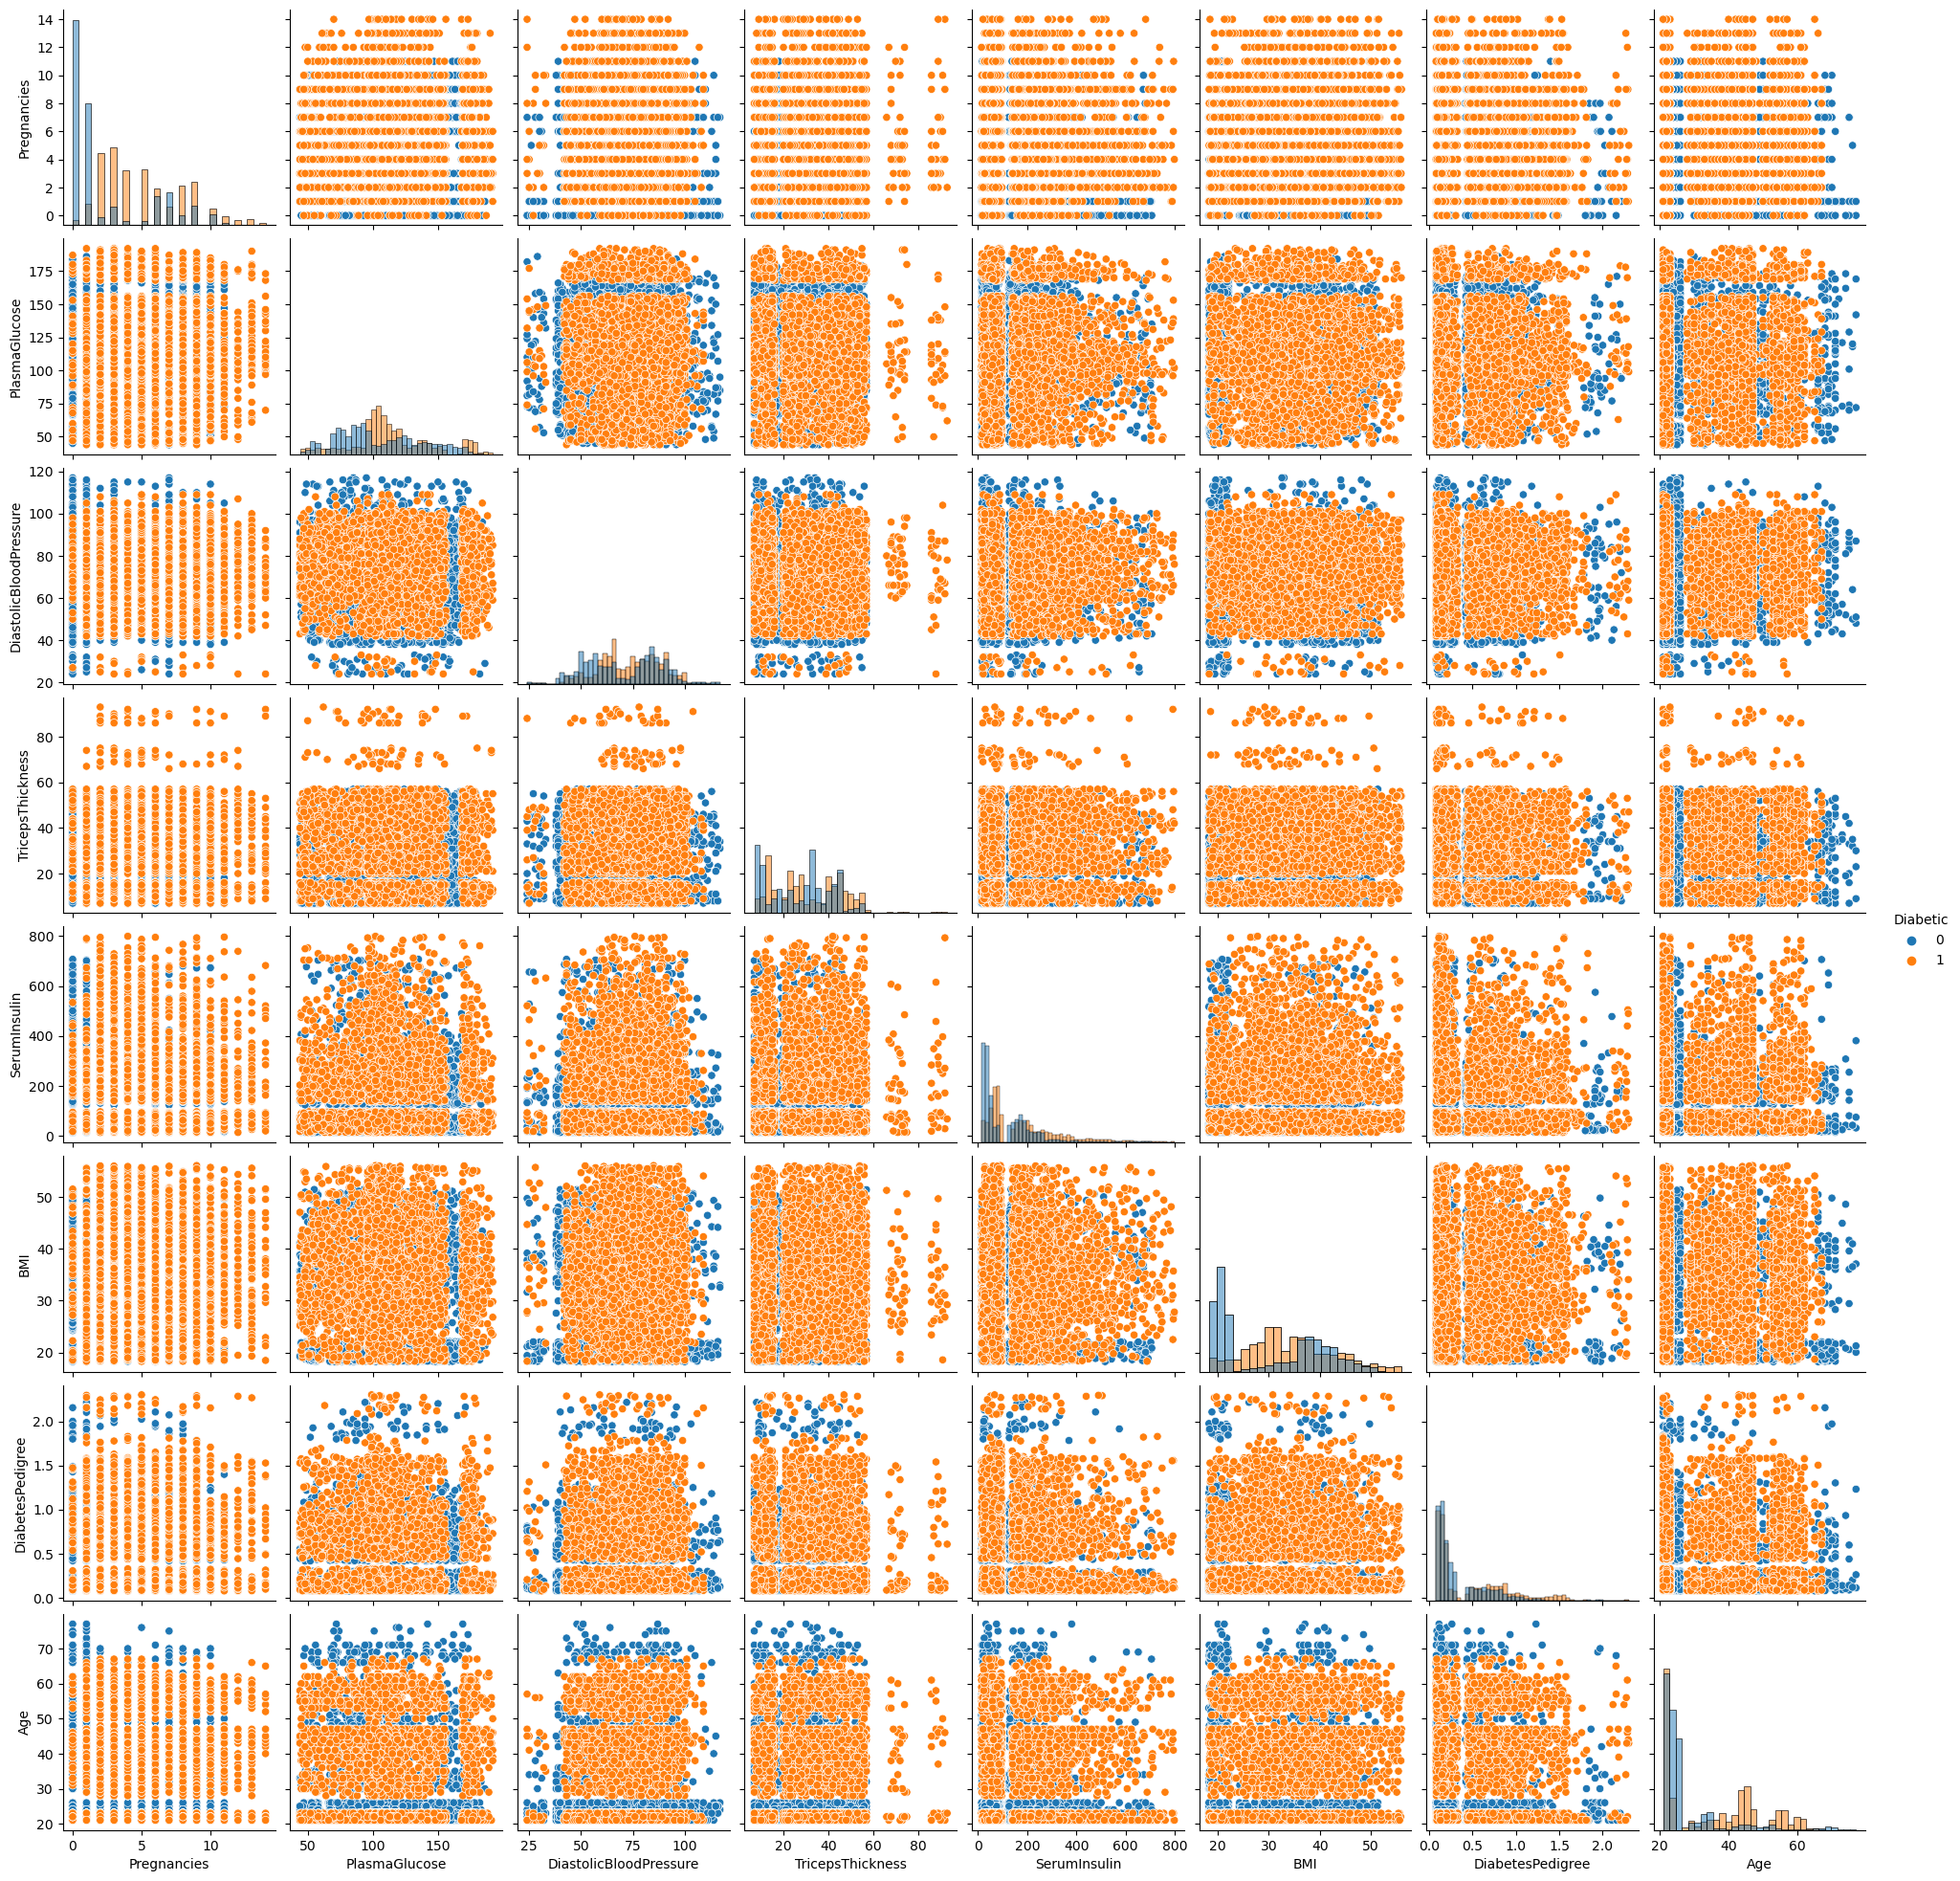

In [15]:
sns.pairplot(df[config.features + [config.label]], hue=config.label, diag_kind="hist")

# Train Test Split

In [16]:
X = df[config.features].values

y = df[config.label].values


In [17]:
# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=config.random_seed) 

print(f"Training Cases: {len(X_train)} \nTest Cases: {len(X_test)}")

Training Cases: 8500 
Test Cases: 1500


# Modelling

In [18]:
# Decision trees with some form of pruning
# Neural networks
# Boosting
# Support Vector Machines
# k-nearest neighbors

In [ ]:
# train a Decisition Tree Classifier model on the training set
model = DecisionTreeClassifier(criterion='gini', 
                               splitter='best', 
                               max_depth=None, 
                               min_samples_split=2, 
                               min_samples_leaf=1, 
                               min_weight_fraction_leaf=0.0, 
                               max_features=None, 
                               random_state=None, #config.random_seed, 
                               max_leaf_nodes=None, 
                               min_impurity_decrease=0.0, 
                               class_weight=None, 
                               ccp_alpha=0.0,
                               )

# model = AdaBoostClassifier(base_estimator=None,
#                            n_estimators=50, 
#                            learning_rate=1.0, 
#                            algorithm='SAMME.R', 
#                            random_state=None
#                           )

# model = KNeighborsClassifier(n_neighbors=5, 
#                              weights='uniform', 
#                              algorithm='auto', 
#                              leaf_size=30, 
#                              p=2, 
#                              metric='minkowski', 
#                              metric_params=None, 
#                              n_jobs=-1
#                             )

model = SVC(C=1.0, 
            kernel='rbf', 
            degree=3, 
            gamma='scale', 
            coef0=0.0, 
            shrinking=True, 
            probability=False, 
            tol=0.001, 
            cache_size=200, 
            class_weight=None, 
            verbose=False, 
            max_iter=-1, 
            decision_function_shape='ovr', 
            break_ties=False, 
            random_state=None
           )

# model = MLPClassifier(hidden_layer_sizes=(100,), 
#                       activation='relu', 
#                       solver='adam', 
#                       alpha=0.0001, 
#                       batch_size='auto', 
#                       learning_rate='constant', 
#                       learning_rate_init=0.001, 
#                       power_t=0.5, 
#                       max_iter=200, 
#                       shuffle=True, 
#                       random_state=None, 
#                       tol=0.0001, 
#                       verbose=False, 
#                       warm_start=False, 
#                       momentum=0.9, 
#                       nesterovs_momentum=True, 
#                       early_stopping=False, 
#                       validation_fraction=0.1, 
#                       beta_1=0.9, 
#                       beta_2=0.999, 
#                       epsilon=1e-08, 
#                       n_iter_no_change=10, 
#                       max_fun=15000
#                      )

# Preprocessing

In [56]:
# # Train the model
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

# # Define preprocessing for numeric columns (normalize them so they're on the same scale)
# # numeric_features = [0,1,2,3,4,5,6]
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])

# # Define preprocessing for categorical features (encode the Age column)
# categorical_features = [7]
# categorical_transformer = Pipeline(steps=[
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# # Combine preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)])

# # Create preprocessing and training pipeline
# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('logregressor', model)])

# # Create preprocessing and training pipeline
# pipeline = Pipeline(steps=[('scaler', StandardScaler()),
#                            ('knn', model)])



# # fit the pipeline to train a logistic regression model on the training set
# model = pipeline.fit(X_train, y_train)
# print (model)

In [ ]:
if isinstance(model, KNeighborsClassifier) or isinstance(model, SVC) or isinstance(model, MLPClassifier):
    scaler = StandardScaler()

    X_train = scaler.fit_transform(X_train)

    X_test = scaler.transform(X_test)

    X = scaler.fit_transform(X) # For timing and validation curve experiments below




# Single Model Fit and Predict

In [ ]:
model.fit(X_train, y_train)

predictions = model.predict(X_test)

# Single Model Evaluation

In [ ]:
print('Accuracy: ', accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))

print(classification_report(y_test,predictions))

In [ ]:
if isinstance(model, DecisionTreeClassifier) or isinstance(model, AdaBoostClassifier):
    print(model.feature_importances_) 

In [ ]:
config.features

In [ ]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import confusion_matrix

# y_scores = model.predict_proba(X_test)

# # calculate ROC curve
# fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

# # plot ROC curve
# fig = plt.figure(figsize=(6, 6))
# # Plot the diagonal 50% line
# plt.plot([0, 1], [0, 1], 'k--')
# # Plot the FPR and TPR achieved by our model
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()

In [ ]:
# from sklearn.metrics import roc_auc_score

# auc = roc_auc_score(y_test,y_scores[:,1])
# print('AUC: ' + str(auc))

# Experiments

## Gridsearch Experiment

In [ ]:
%%time

if isinstance(model, DecisionTreeClassifier):
    param_grid = { 
        'criterion' : ["gini", "entropy", "log_loss"],
        'max_depth' : [int(x) for x in np.linspace(1, 20, num = 20)],
#         'min_samples_split' : [int(x) for x in np.linspace(2, 50, num = 10)],
#         'min_samples_leaf' : [int(x) for x in np.linspace(1, 20, num = 10)],
#         'max_features' : [int(x) for x in np.linspace(2, X.shape[1], num = X.shape[1]-1)]
    }
elif isinstance(model, AdaBoostClassifier):
    param_grid = { 
        "n_estimators": [int(x) for x in np.linspace(1, 100, num = 20)], 
        "learning_rate": [float(x) for x in np.linspace(0.1, 2.0, 20)],
        "algorithm": ['SAMME', 'SAMME.R'], 
    }
elif isinstance(model, KNeighborsClassifier):
    param_grid = { 
        "n_neighbors": [int(x) for x in np.linspace(1, 50, num = 50)], 
#         "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'] , 
        "p": [int(x) for x in np.linspace(1, 3, num = 3)], 

    }
elif isinstance(model, SVC):
    param_grid = { 
        "C": [float(x) for x in np.linspace(0.1, 10.1, 21)], 
        "kernel": ["linear", "poly", "rbf", "sigmoid"], 
#         degree=3, 
#         gamma='scale', 
#         coef0=0.0, 
#         shrinking=True, 
#         probability=False, 
#         tol=0.001, 
#         cache_size=200, 
#         class_weight=None, 
#         verbose=False, 
#         max_iter=-1, 
#         decision_function_shape='ovr', 
#         break_ties=False, 
#         random_state=None
    }
else: #MLPClassifier()
    param_grid = { 
        "hidden_layer_sizes": [(int(x),) for x in np.linspace(1, 150, num = 16)] + [(130,130), (130,130,130)],
        'max_iter': [500,1000,1500,2000], 
        'alpha': 10.0 ** -np.arange(1, 7), 
#         activation='relu', 
#         'solver':['lbfgs', 'sgd', 'adam'], 
#         alpha=0.0001, 
#         batch_size='auto', 
#         'learning_rate':["constant", "invscaling", "adaptive"] 
#         learning_rate_init=0.001, 
#         power_t=0.5, 
#         max_iter=200, 
#         shuffle=True, 
#         random_state=None, 
#         tol=0.0001, 
#         verbose=False, 
#         warm_start=False, 
#         momentum=0.9, 
#         nesterovs_momentum=True, 
#         early_stopping=True, 
#         validation_fraction=0.1, 
#         beta_1=0.9, 
#         beta_2=0.999, 
#         epsilon=1e-08, 
#         n_iter_no_change=100, 
#         max_fun=15000
    }

grid_search = GridSearchCV(model, param_grid, cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X, y)

In [ ]:
# %%time 
# param_grid = { 
#         "n_neighbors": [int(x) for x in np.linspace(, 1000, num = 20)], 
#         "weights": ['uniform', 'distance'] ,
#         "p": [int(x) for x in np.linspace(1, 12, num = 12)], 
#     }

# pipeline = Pipeline(steps=[('scaler', StandardScaler()),
#                            ('grid', GridSearchCV(model, param_grid, cv=5, verbose=2, n_jobs=-1))])
# pipeline.fit(X_train, y_train)

In [ ]:
grid_search_experiment_df = pd.DataFrame(grid_search.cv_results_)
grid_search_experiment_df.head()

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
if isinstance(model, DecisionTreeClassifier) or isinstance(model, AdaBoostClassifier):
#     print(grid_search.best_estimator_.feature_importances_) 
    dfz = pd.DataFrame(zip(config.features, grid_search.best_estimator_.feature_importances_), columns=["Feature", "Feature Importance"])
    dfz.sort_values(by="Feature Importance", ascending=False, inplace=True)
    dfz.plot(kind='bar', x='Feature', y='Feature Importance', title=f"Feature Importances - {config.dataset_name}", figsize=(6,2))


In [70]:
config.features

['Pregnancies',
 'PlasmaGlucose',
 'DiastolicBloodPressure',
 'TricepsThickness',
 'SerumInsulin',
 'BMI',
 'DiabetesPedigree',
 'Age']

In [71]:
# grid_search_experiment_df[(grid_search_experiment_df['param_criterion'] == 'entropy')
#                           # & (grid_search_experiment_df['param_min_samples_leaf'] == 1)
#                           # & (grid_search_experiment_df['param_min_samples_split'] == 2)
#                           # & (grid_search_experiment_df['param_max_depth'] == 9)
#                          ].plot("param_max_depth", "mean_test_score", style="o-")

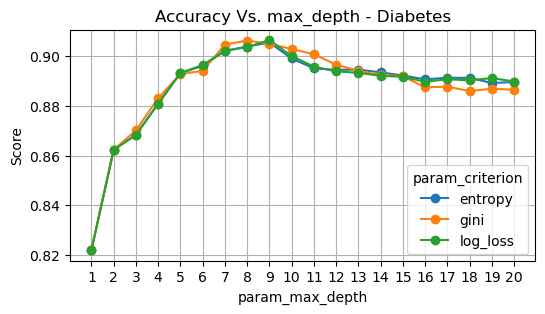

In [72]:
fig, ax = plt.subplots()
grid_search_experiment_df.pivot_table(values="mean_test_score", index="param_max_depth", columns="param_criterion").plot(marker="o", ax=ax, figsize=(6,3))
# sns.lineplot("param_max_depth", "mean_test_score", hue="param_criterion", data=grid_search_experiment_df, marker="o", ax=ax)
ax.set_xticks(param_grid['max_depth'])
ax.set_ylabel("Score")
ax.set_title(f"Accuracy Vs. max_depth - {config.dataset_name}")
ax.grid()

In [ ]:
# same plot using Seaborn
# fig = px.line(grid_search_experiment_df, x="param_max_depth", y="mean_test_score", color='param_criterion')
# fig.show()

## Timing Experiment 

In [37]:
# splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
# reps = 5 # number of times to run each experiment for mean calculation

# fit_times = np.zeros(shape=(len(splits), reps))
# pred_times = np.zeros(shape=(len(splits), reps))
# test_accuracies = np.zeros(shape=(len(splits), reps))
# train_accuracies = np.zeros(shape=(len(splits), reps))

# for i, split in enumerate(tqdm(splits)):
#     for j in range(reps):
#         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split,)# random_state=config.random_seed) 

#         # Get time to fit model
#         start_time = time.time()
#         grid_search.best_estimator_.fit(X_train, y_train)
#         end_time = time.time()
#         wall_time = end_time - start_time
#         fit_times[i, j] = wall_time

#         # Get time to make test_predictions
#         start_time = time.time()
#         test_predictions = grid_search.best_estimator_.predict(X_test)
#         end_time = time.time()
#         wall_time = end_time - start_time
#         pred_times[i, j] = wall_time
        
#         #train_predictions = model.predict(X_train)

#         train_accuracies[i, j] = grid_search.best_estimator_.score(X_train, y_train)#accuracy_score(y_train, train_predictions)
#         test_accuracies[i, j] = grid_search.best_estimator_.score(X_test, y_test) #accuracy_score(y_test, test_predictions)
        
# # Calculate the average of reps
# mean_train_accuracies = np.mean(train_accuracies, axis=1)
# mean_test_accuracies = np.mean(test_accuracies, axis=1)
# mean_fit_times = np.mean(fit_times, axis=1)
# mean_pred_times = np.mean(pred_times, axis=1)

# # Store results in df
# time_experiment_df = pd.DataFrame({"train_size": splits, 
#                                    "mean_fit_times": mean_fit_times, 
#                                    "mean_pred_times": mean_pred_times, 
#                                    "mean_train_accuracies": mean_train_accuracies, 
#                                    "mean_test_accuracies": mean_test_accuracies})
# time_experiment_df


In [38]:
# time_experiment_df['mean_train_loss'] = 1 - time_experiment_df['mean_train_accuracies'] 
# time_experiment_df['mean_test_loss'] = 1 - time_experiment_df['mean_test_accuracies'] 

# time_experiment_df.plot(x="train_size", y=["mean_train_loss", "mean_test_loss"])
# # time_experiment_df.plot(x="train_size", y=["mean_test_accuracies", "mean_train_accuracies"])

### Learning Curve

In [ ]:
%%time

# Code shamelessly copied from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

train_sizes, train_scores, test_scores, fit_times, score_times  = learning_curve(grid_search.best_estimator_, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, return_times=True, shuffle=True)
# train_sizes, train_scores, test_scores, fit_times, score_times  = learning_curve(tuned_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, return_times=True, shuffle=True)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Plot learning curve
axes[0].grid()
axes[0].fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
axes[0].fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
axes[0].plot(
    train_sizes, train_scores_mean, "o-", color="r", label="Training score"
)
axes[0].plot(
    train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
)
axes[0].legend(loc="best")
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Score")
axes[0].set_title(f"Learning Curves - {config.dataset_name}")

# # Plot n_samples vs fit_times
# axes[1].grid()
# axes[1].plot(train_sizes, fit_times_mean, "o-")
# axes[1].fill_between(
#     train_sizes,
#     fit_times_mean - fit_times_std,
#     fit_times_mean + fit_times_std,
#     alpha=0.1,
# )
# axes[1].set_xlabel("Training examples")
# axes[1].set_ylabel("fit_times")
# axes[1].set_title(f"Scalability of the model - {config.dataset_name}")

### Loss Curve for MLP

In [ ]:
%%time

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax1.plot(grid_search.best_estimator_.loss_curve_, label="best_estimator10e-3")

mlp_pt1 = MLPClassifier(alpha=1e-05, 
                        hidden_layer_sizes=(130,), 
                        max_iter=1500,
                        early_stopping=True,
                        n_iter_no_change=100,
                        learning_rate_init = 0.1)
mlp_pt01 = MLPClassifier(alpha=1e-05, 
                        hidden_layer_sizes=(130,), 
                        max_iter=1500,
                        early_stopping=True,
                         n_iter_no_change=100,
                        learning_rate_init = 0.01)
# mlp_pt001 = MLPClassifier(alpha=1e-05, 
#                         hidden_layer_sizes=(130,), 
#                         max_iter=1500,
#                         early_stopping=True,
#                           n_iter_no_change=100,
#                         learning_rate_init = 0.001)
mlp_pt0001 = MLPClassifier(alpha=1e-05, 
                        hidden_layer_sizes=(130,), 
                        max_iter=1500,
                        early_stopping=True,
                           n_iter_no_change=100,
                        learning_rate_init = 0.0001)

mlp_pt1.fit(X_train, y_train)
mlp_pt01.fit(X_train, y_train)
# mlp_pt001.fit(X_train, y_train)
mlp_pt0001.fit(X_train, y_train)

ax1.plot(mlp_pt1.loss_curve_, label="learning_rate10e-1", alpha=0.5)
ax1.plot(mlp_pt01.loss_curve_, label="learning_rate10e-2", alpha=0.5)
# ax1.plot(mlp_pt001.loss_curve_, label="learning_rate10e-1")
ax1.plot(mlp_pt0001.loss_curve_, label="learning_rate10e-4", alpha=0.5)
ax1.legend()

plt.title(f"Loss Curve - {config.dataset_name}")
plt.xlabel(f"Iterations")
plt.ylabel("Loss")

### Validation Curves

In [87]:
tuned_model = joblib.load("./Models/hypertuned_SVC().pkl")

In [ ]:
%%time 
# Code shamelessly copied from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py

# DecisionTree
param_name = "max_depth"
param_range = [int(x) for x in np.linspace(1, 20, num = 20)]
# param_name = "criterion"
# param_range = ["gini", "entropy", "log_loss"]

# AdaBoost
param_name = "learning_rate"
param_range = [float(x) for x in np.linspace(0.1, 1.8, 18)]
param_name = "n_estimators"
param_range = [int(x) for x in np.linspace(1, 200, num = 20)]

# KNN
param_name = "n_neighbors"
param_range = [int(x) for x in np.linspace(1, 30, 30)]
param_name = "p"
param_range = [int(x) for x in np.linspace(1, 12, 12)]

# SVM
param_name = "C"
param_range = [float(x) for x in np.linspace(0.1, 10.1, 21)]
param_name = "kernel"
param_range = ["linear", "poly", "rbf", "sigmoid"]

# # # NN
# param_name = "hidden_layer_sizes"
# param_range = [(int(x),) for x in np.linspace(1, 150, num = 16)]
# param_range = [(30,), (30,30), (30,30,30), (30,30,30,30)]
# param_range = [(130,), (130,130), (130,130,130), (130,130,130,130)]

# param_name = 'activation'
# param_range = ["identity", "logistic", "tanh", "relu"]
# param_name = "max_iter"
# param_range = list(np.arange(100, 2000, 100))
# param_name = "solver"
# param_range = ["lbfgs", "sgd", "adam"]
# param_name = "learning_rate"
# param_range = ["constant", "invscaling", "adaptive"] 

train_scores, test_scores = validation_curve(
    tuned_model, #grid_search.best_estimator_,
    X,
    y,
    param_name=param_name,
    param_range=param_range,
    scoring="accuracy",
    n_jobs=-1,
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# specifically to for hidden_layer_sizes of NN
if param_name == "hidden_layer_sizes":
    param_range = [str(x) for x in param_range]

plt.figure(figsize=(6,3))
lw = 2
plt.plot(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw, marker="o", 
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.plot(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw, marker="o"
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.title(f"Validation Curve with {model} - {config.dataset_name}")
plt.xlabel(f"{param_name}")
plt.ylabel("Score")
# plt.xscale('log')
# plt.ylim(0.7, 1.1)
plt.legend(loc="best")
plt.grid()
plt.xticks(param_range)
plt.xticks(rotation=45)
plt.show()

# Save Model

In [ ]:
# # Save the model as a pickle file
# filename = f'./Models/{config.dataset_name}/hypertuned_{model}.pkl'
# joblib.dump(grid_search.best_estimator_, filename)

# Comparison Between Models

In [ ]:
%%time

# Code shamelessly copied from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

# assign directory
directory = './Models/breast_cancer'
 
# iterate over files in that directory
tuned_models = Path(directory).glob('hypertuned_*')

for tuned_model in tuned_models:

    tuned_model = joblib.load(tuned_model)
    if isinstance(tuned_model, DecisionTreeClassifier):
        label = "DecisionTreeClassifier"
    elif isinstance(tuned_model, AdaBoostClassifier):
        label = "AdaBoostClassifier"
    elif isinstance(tuned_model, KNeighborsClassifier):
        label = "KNeighborsClassifier"
    elif isinstance(tuned_model, SVC):
        label = "SVC"
    else:
        label = "MLPClassifier"
#         continue
    
    
    train_sizes, train_scores, test_scores, fit_times, score_times  = learning_curve(tuned_model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=10, return_times=True, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))

    # Plot learning curve
    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    ax.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    ax.legend(loc="best")
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.set_title(f"{label} Learning Curves")
    ax.set_ylim(0.85, 1.03)

In [ ]:
%%time
# Create a graph of combined fit times
# Code shamelessly copied from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
 
# assign directory
directory = './Models/breast_cancer'
 
# iterate over files in that directory
tuned_models = Path(directory).glob('hypertuned_*')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(23, 5))

for tuned_model in tuned_models:

    tuned_model = joblib.load(tuned_model)

    if isinstance(tuned_model, DecisionTreeClassifier):
        label = "DecisionTreeClassifier"
        color = "orange"
    elif isinstance(tuned_model, AdaBoostClassifier):
        label = "AdaBoostClassifier"
        color = "tab:blue"
    elif isinstance(tuned_model, KNeighborsClassifier):
        label = "KNeighborsClassifier"
        color = "green"
    elif isinstance(tuned_model, SVC):
        label = "SVC"
        color = "red"
    else:
        label = "MLPClassifier"
        color = "tab:purple"
#         continue
    
    train_sizes, train_scores, test_scores, fit_times, score_times  = learning_curve(tuned_model, X, y, train_sizes=np.linspace(0.1, 1.0, 11), cv=5, return_times=True, shuffle=True)
    fit_times, score_times = fit_times*1000, score_times*1000
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)
    
    if isinstance(tuned_model, KNeighborsClassifier):
        score_times_mean[0] = np.min(score_times[0])

    # Plot n_samples vs fit_times
    ax[0].grid()
    ax[0].plot(train_sizes, fit_times_mean, "o-", color=color, label=label)
    ax[0].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
        color=color
    )
    
    # Plot n_samples vs fit_times
    ax[1].grid()
    ax[1].plot(train_sizes, score_times_mean, "o-", color=color, label=label)
#     ax[1].fill_between(
#         train_sizes,
#         score_times_mean - score_times_std,
#         score_times_mean + score_times_std,
#         alpha=0.1,
#     )
    
ax[0].set_xlabel("Training examples", fontsize=18)
ax[0].set_ylabel("Training fit_times (ms)", fontsize=18)
ax[0].set_title("Scalability of the model - Training", fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[0].legend(fontsize=15)
ax[0].grid()

ax[1].set_xlabel("Training examples", fontsize=18)
ax[1].set_ylabel("Predict Times (ms)", fontsize=18)
ax[1].set_title("Scalability of the model - Predicting", fontsize=25)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[1].legend(fontsize=15)
ax[1].grid()

# Scratch Work

In [ ]:
# #Visualizing KNN Decision Boundary

# from matplotlib.colors import ListedColormap
# from sklearn.inspection import DecisionBoundaryDisplay

# n_neighbors = 9

# X = df[config.features].iloc[:, [0]+[-1]]

# # Create color maps
# cmap_light = ListedColormap(["orange", "cyan"])
# cmap_bold = ["darkorange", "c"]

# for weights in ["uniform", "distance"]:
#     # we create an instance of Neighbours Classifier and fit the data.
#     clf = KNeighborsClassifier(n_neighbors, weights=weights)
#     clf.fit(X, y)

#     _, ax = plt.subplots()
#     DecisionBoundaryDisplay.from_estimator(
#         clf,
#         X,
#         cmap=cmap_light,
#         ax=ax,
#         response_method="predict",
#         plot_method="pcolormesh",
#         xlabel=X.columns[0],
#         ylabel=X.columns[1],
#         shading="auto",
#     )

#     # Plot also the training points
#     sns.scatterplot(
#         x=X.iloc[:, 0],
#         y=X.iloc[:, 1],
#         hue=y,
#         palette=cmap_bold,
#         alpha=1.0,
#         edgecolor="black",
#     )
#     plt.title(
#         "KNN Classifier (k = %i, weights = '%s')" % (n_neighbors, weights)
#     )

# plt.show()

In [ ]:
# from sklearn import svm
# from sklearn.inspection import DecisionBoundaryDisplay

# X = df[config.features].iloc[:, [0]+[-1]]

# # we create an instance of SVM and fit out data. We do not scale our
# # data since we want to plot the support vectors
# C = 1.0  # SVM regularization parameter
# models = (
#     svm.SVC(kernel="linear", C=C),
#     svm.LinearSVC(C=C, max_iter=10000),
#     svm.SVC(kernel="rbf", gamma=0.7, C=C),
#     svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
# )
# models = (clf.fit(X, y) for clf in models)

# # title for the plots
# titles = (
#     "SVC with linear kernel",
#     "LinearSVC (linear kernel)",
#     "SVC with RBF kernel",
#     "SVC with polynomial (degree 3) kernel",
# )

# # Set-up 2x2 grid for plotting.
# fig, sub = plt.subplots(2, 2)
# plt.subplots_adjust(wspace=0.4, hspace=0.4)

# X0, X1 = X.iloc[:, 0], X.iloc[:, 1]

# for clf, title, ax in zip(models, titles, sub.flatten()):
#     disp = DecisionBoundaryDisplay.from_estimator(
#         clf,
#         X,
#         response_method="predict",
#         cmap=plt.cm.coolwarm,
#         alpha=0.8,
#         ax=ax,
#         xlabel=X.columns[0],
#         ylabel=X.columns[1],
#     )
#     ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
#     ax.set_xticks(())
#     ax.set_yticks(())
#     ax.set_title(title)

# plt.show()